# (0) Importações e Metodologia

In [ ]:
!pip install pulp joblib --quiet

In [ ]:
import os
import re
import time
import glob
import nltk
import tarfile
import numpy as np
import pandas as pd
import urllib.request
from itertools import chain
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from scipy.sparse import issparse
from tqdm import tqdm

from pprint import pprint
from joblib import Parallel, delayed
import pulp
import random
import itertools
from itertools import combinations
import random

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, fbeta_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif, chi2
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier

from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

## Metodologia:

1. Problema: seleção de features para classificação de texto (maximizar informação por documento / minimizar número de features), inspirado em Huang et al. (2018).

2. Objetivo final: reduzir dimensionalidade sem perder poder discriminativo.

3. Datasets: Reuters-21578 (pré-processado a partir de .sgm) e 20Newsgroups (subconjunto testado).

4. Preparação: Limpeza, Stemming, Vetorização

5. Modelagem:
- MILP, Programação Dinâmica (DP), e DP paralelizado (`dp_pareto_feature_selection_parallel`).

- Benchmarks: DummyClassifier `SelectKBest(chi2)` + `GridSearchCV`.

- Pipeline: Vetorizador → Seleção de features → Classificador (NB ou LinearSVC).

6. Avaliação:
- Métricas: `accuracy` e `micro-F1`.
- Procedimentos: holdout (train/test) e validação cruzada para GridSearch.


# (1) Preparação

## (1.1) Baixando e extraindo o Reuters-21578
Referência: https://www.daviddlewis.com/resources/testcollections/reuters21578/

In [ ]:
# URL do dataset
url = "http://www.daviddlewis.com/resources/testcollections/reuters21578/reuters21578.tar.gz"
dataset_dir = "reuters21578"

# Download do dataset
os.makedirs(dataset_dir, exist_ok=True)
archive_path = os.path.join(dataset_dir, "reuters21578.tar.gz")

if not os.path.exists(archive_path):
  print("Baixando Reuters-21578...")
  urllib.request.urlretrieve(url, archive_path)
else:
  print("Arquivo já existente.")

# Extração
with tarfile.open(archive_path, "r:gz") as tar:
  tar.extractall(path=dataset_dir)

print("Arquivos extraídos para:", os.path.abspath(dataset_dir))

Arquivo já existente.


/tmp/ipython-input-3925252245.py:17: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=dataset_dir)


Arquivos extraídos para: /content/reuters21578


## (1.2) Parse de arquivos SGML

Os arquivos .sgm são coleções de documentos Reuters com metadados SGML.
A seguir serão extraídos título, texto e tópicos.

In [ ]:
# Função para ler documentos Reuters (.sgm)
def parse_reuters_sgm(file_path):
  with open(file_path, "r", encoding="latin-1") as f:
    data = f.read()
  soup = BeautifulSoup(data, "html.parser")
  docs = []
  for reuters in soup.find_all("reuters"):
    # tópicos
    topics = [t.text for t in reuters.topics.find_all("d")] if reuters.topics else []

    # tag <text>
    text_tag = reuters.find("text")

    # extrai título e corpo
    title = text_tag.find("title").text if text_tag and text_tag.find("title") else ""
    body = text_tag.find("body").text if text_tag and text_tag.find("body") else ""

    docs.append({"title": title, "body": body, "topics": topics})
  return docs

# Lendo arquivos .sgm
all_docs = []
for file in sorted(glob.glob(os.path.join(dataset_dir, "*.sgm"))):
  all_docs.extend(parse_reuters_sgm(file))

print(f"Total de documentos extraídos: {len(all_docs)}")

# Converter em DataFrame
df = pd.DataFrame(all_docs)
df = df[df["topics"].map(len) > 0] # remove sem tópico
print(f"Documentos com tópicos: {len(df)}")

df.head(10)

Total de documentos extraídos: 21578
Documentos com tópicos: 11367


,title,body,topics
0,BAHIA COCOA REVIEW,Showers continued throughout the week in\nthe ...,[cocoa]
4,NATIONAL AVERAGE PRICES FOR FARMER-OWNED RESERVE,The U.S. Agriculture Department\nreported the ...,"[grain, wheat, corn, barley, oat, sorghum]"
5,ARGENTINE 1986/87 GRAIN/OILSEED REGISTRATIONS,Argentine grain board figures show\ncrop regis...,"[veg-oil, linseed, lin-oil, soy-oil, sun-oil, ..."
8,CHAMPION PRODUCTS <CH> APPROVES STOCK SPLIT,Champion Products Inc said its\nboard of direc...,[earn]
9,COMPUTER TERMINAL SYSTEMS <CPML> COMPLETES SALE,Computer Terminal Systems Inc said\nit has com...,[acq]
10,COBANCO INC <CBCO> YEAR NET,"Shr 34 cts vs 1.19 dlrs\n Net 807,000 vs 2,...",[earn]
11,OHIO MATTRESS <OMT> MAY HAVE LOWER 1ST QTR NET,"Ohio Mattress Co said its first\nquarter, endi...","[earn, acq]"
12,AM INTERNATIONAL INC <AM> 2ND QTR JAN 31,Oper shr loss two cts vs profit seven cts\n ...,[earn]
13,BROWN-FORMAN INC <BFD> 4TH QTR NET,Shr one dlr vs 73 cts\n Net 12.6 mln vs 15....,[earn]
17,DEAN FOODS <DF> SEES STRONG 4TH QTR EARNINGS,Dean Foods Co expects earnings for the\nfourth...,[earn]


## (1.3) Explorando o corpus

Total de tópicos únicos: 120
earn        3987
acq         2448
money-fx     801
crude        634
grain        628
trade        552
interest     513
wheat        306
ship         305
corn         254
Name: count, dtype: int64


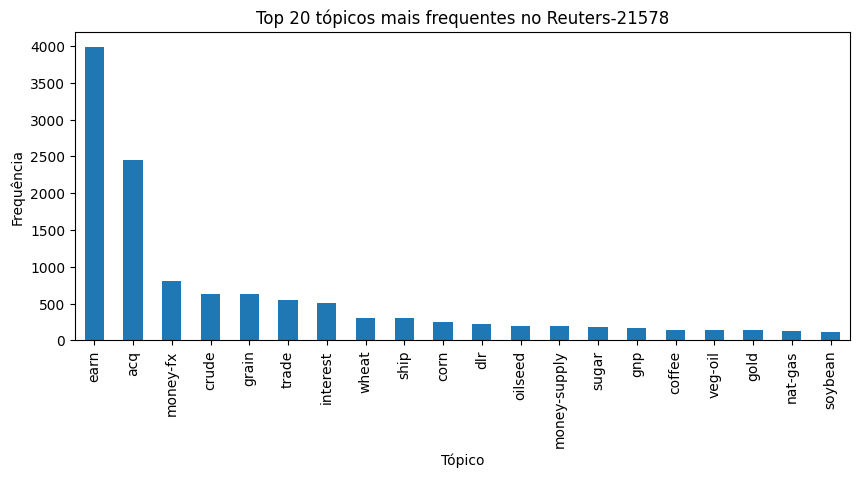

Título: BAHIA COCOA REVIEW
Tópicos: ['cocoa']
Corpo:
 Showers continued throughout the week in
the Bahia cocoa zone, alleviating the drought since early
January and improving prospects for the coming temporao,
although normal humidity levels have not been restored,
Comissaria Smith said in its weekly review.
    The dry period means the temporao will be late this year.
    Arrivals for the week ended February 22 were 155,221 bags
of 60 kilos making a cumulative total for the season of 5.93
mln against 5.81 at the same stage last year. Again it seem ...


In [ ]:
# Quantidade de tópicos únicos
topics = list(chain.from_iterable(df["topics"]))
topic_counts = pd.Series(topics).value_counts()

print(f"Total de tópicos únicos: {len(topic_counts)}")
print(topic_counts.head(10))

# Distribuição dos tópicos
plt.figure(figsize=(10, 4))
topic_counts.head(20).plot(kind="bar")
plt.title("Top 20 tópicos mais frequentes no Reuters-21578")
plt.xlabel("Tópico")
plt.ylabel("Frequência")
plt.show()

# Exemplo de texto
example = df.iloc[0]
print("Título:", example["title"])
print("Tópicos:", example["topics"])
print("Corpo:\n", example["body"][:500], "...")

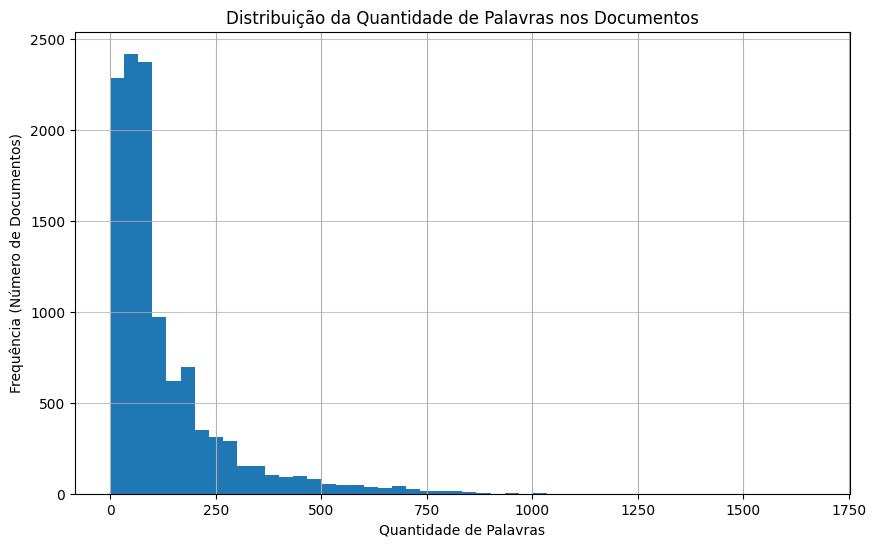


Estatísticas da Contagem de Palavras:
count    11367.000000
mean       124.193279
std        138.822437
min          0.000000
25%         41.000000
50%         81.000000
75%        160.000000
max       1669.000000
Name: word_count, dtype: float64


In [ ]:
df['word_count'] = df['body'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10, 6))

df['word_count'].hist(bins=50)

plt.title('Distribuição da Quantidade de Palavras nos Documentos')
plt.xlabel('Quantidade de Palavras')
plt.ylabel('Frequência (Número de Documentos)')
plt.grid(axis='y', alpha=0.75)
plt.show()

print("\nEstatísticas da Contagem de Palavras:")
print(df['word_count'].describe())

## (1.4) Pré-processamento (baseado no artigo)

Explicitamente, o artigo menciona: "Removemos pontuação, números, endereços de páginas web e e-mails. Todos os termos são stemmed usando o Lovins stemmer. Features que aparecem em menos de 1% dos documentos são consideradas ruído. Da mesma forma, características que aparecem em mais de 95% dos documentos são consideradas stopword."

**stemming**: redução de radicais ou tronco. Procedimento de pré-processamento de texto que consiste em reduzir palavras flexionadas (variantes) à sua forma-base, ou "radical". O objetivo é tratar formas diferentes de uma mesma palavra como uma única entidade, o que simplifica o vocabulário e ajuda a melhorar o desempenho

In [ ]:
nltk.download('stopwords')
stemmer = SnowballStemmer("english")  # Lovins não está no NLTK; Snowball é uma aproximação
stop_words = set(stopwords.words("english"))

def clean_text(text):
  text = text.lower()
  text = re.sub(r"http\S+|www\S+|@\S+|#\S+", " ", text) # remove URLs e mentions
  text = re.sub(r"\d+", " ", text)                      # remove números
  text = re.sub(r"[^a-z\s]", " ", text)                 # remove pontuação
  tokens = [stemmer.stem(t) for t in text.split() if t not in stop_words and len(t) > 2]
  return " ".join(tokens)

df["clean_text"] = df["body"].apply(clean_text)
df["clean_text"].head(3)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,clean_text
0,shower continu throughout week bahia cocoa zon...
4,agricultur depart report farmer own reserv nat...
5,argentin grain board figur show crop registr g...


## (1.5) Definir X e y

In [ ]:
# Inicialmente apenas um rótulo principal por documento
# (no artigo, eles fazem classificação multi-classe com os datasets definidos)
df["label"] = df["topics"].apply(lambda x: x[0])

# Remover documentos associados a tópicos muito raros
# Contar a frequência dos rótulos principais
label_counts = df['label'].value_counts()

# 2. Identificar os rótulos a serem mantidos (exemplo: pelo menos 5 documentos)
min_docs = 5
labels_to_keep = label_counts[label_counts >= min_docs].index

# Filtrar o DataFrame
df_filtered = df[df['label'].isin(labels_to_keep)]

print(f"Documentos antes da filtragem: {len(df)}")
print(f"Documentos após filtragem de classes raras (<{min_docs}): {len(df_filtered)}")

X = df_filtered["clean_text"].values

y_multi_label = df_filtered["topics"].values

# Binarizar os rótulos
mlb = MultiLabelBinarizer()
y_binarized = mlb.fit_transform(y_multi_label)

print("X (textos): ", X.shape)
print("Shape de y_binarized (documentos x rótulos):", y_binarized.shape)

Documentos antes da filtragem: 11367
Documentos após filtragem de classes raras (<5): 11318
X (textos):  (11318,)
Shape de y_binarized (documentos x rótulos): (11318, 117)


##(1.6) Vetorização (TF-IDF e Count)

In [ ]:
# No artigo, falam que: features que aparecem em menos de 1% dos documentos são consideradas ruído.
#                       features que aparecem em mais de 95% dos documentos são consideradas stopword.

# Se for feito:

# TF-IDF
tfidf = TfidfVectorizer(max_df=0.95, min_df=0.01) # ignora <1% e >99%
X_tfidf = tfidf.fit_transform(X)

# Count
count = CountVectorizer(max_df=0.95, min_df=0.01)
X_count = count.fit_transform(X)

print("TF-IDF shape:", X_tfidf.shape)
print("Count shape:", X_count.shape)

# 874 features no máximo (não condiz com os resultados do artigo)

TF-IDF shape: (11318, 874)
Count shape: (11318, 874)


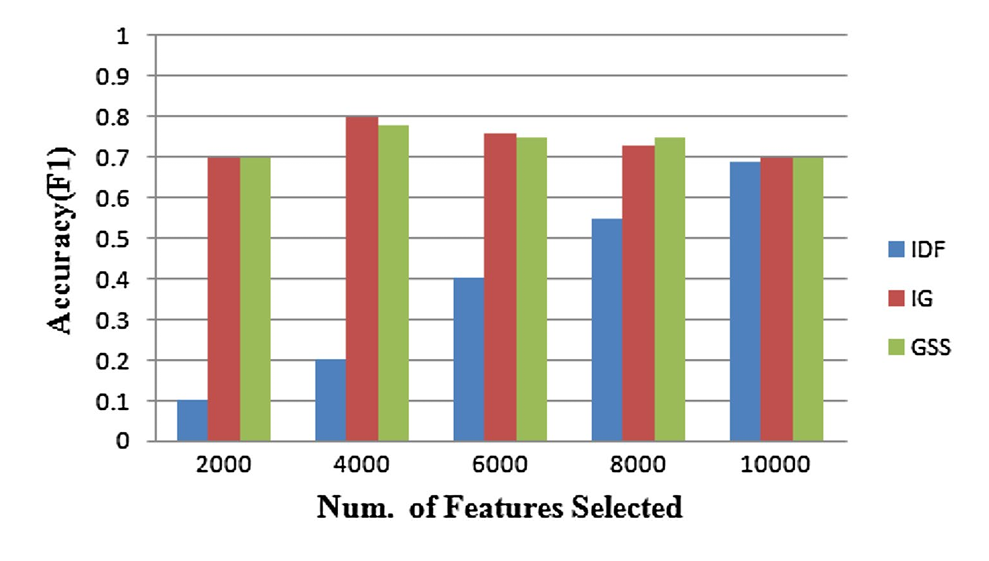

In [ ]:
# TF-IDF
tfidf = TfidfVectorizer(max_df=0.95, min_df=0.001) # ignora <0.1% e >99%
X_tfidf = tfidf.fit_transform(X)

# Count
count = CountVectorizer(max_df=0.95, min_df=0.001)
X_count = count.fit_transform(X)

print("TF-IDF shape:", X_tfidf.shape)
print("Count shape:", X_count.shape)

# Muito caro computacionalmente

TF-IDF shape: (11318, 3443)
Count shape: (11318, 3443)


In [ ]:
# TF-IDF
tfidf = TfidfVectorizer(max_df=0.95, min_df=0.005) # ignora <0.5% e >99%
X_tfidf = tfidf.fit_transform(X)

# Count
count = CountVectorizer(max_df=0.95, min_df=0.005)
X_count = count.fit_transform(X)

print("TF-IDF shape:", X_tfidf.shape)
print("Count shape:", X_count.shape)

TF-IDF shape: (11318, 1419)
Count shape: (11318, 1419)


In [ ]:
# TF-IDF
tfidf = TfidfVectorizer() # maximo de features
X_tfidf = tfidf.fit_transform(X)

# Count
count = CountVectorizer()
X_count = count.fit_transform(X)

print("TF-IDF shape:", X_tfidf.shape)
print("Count shape:", X_count.shape)

TF-IDF shape: (11318, 18719)
Count shape: (11318, 18719)


## (1.7) Funções de pontuação (IG, χ², MI)

In [ ]:
# Function to aggregate mutual information scores across labels (not used in final approach but kept for context)
def aggregate_mutual_info(X, Y_binarized):
  aggregated_scores = np.zeros(X.shape[1])
  for i in range(Y_binarized.shape[1]):
    y_label = Y_binarized[:, i]
    # Ensure y_label is not all the same value (constant) which causes issues for mutual_info_classif
    if len(np.unique(y_label)) > 1:
      scores = mutual_info_classif(X, y_label, discrete_features=True, random_state=42)
      aggregated_scores += scores
  return aggregated_scores

# Function to aggregate chi2 scores across labels
def aggregate_chi2(X, Y_binarized):
  # chi2(X, Y) returns a matrix (features x labels)
  chi2_matrix, _ = chi2(X, Y_binarized)

  if chi2_matrix.ndim == 2:
    # Agrega somando as pontuações de cada feature sobre todos os rótulos (eixo 1)
    return np.sum(chi2_matrix, axis=1)
  else:
    # Se for uni-rótulo (1D), o vetor já contém a pontuação final para cada feature.
    return chi2_matrix

In [ ]:
# # Information Gain (IG) Multi-Rótulo
# ig_scores_count = aggregate_mutual_info(X_count, y_binarized)

# # Chi-quadrado (CHI2) Multi-Rótulo
# chi2_scores_count = aggregate_chi2(X_count, y_binarized)

# scores_df_count = pd.DataFrame({
#     "feature": count.get_feature_names_out(),
#     "IG": ig_scores_count,
#     "CHI2": chi2_scores_count
# }).sort_values(by="IG", ascending=False)

# print("Dataframe das pontuações")
# print(scores_df_count.head(5))

# (2) Análise Preliminar

## (2.1) F1-score x Número de features

In [ ]:
def calculate_nonzero_document_percentage(X_sparse):
  """
  Calcula a porcentagem de documentos (linhas) que têm pelo menos um
  valor não-zero na matriz esparsa.
  """
  if not issparse(X_sparse):
    # Garante que a matriz é esparsa para usar o método .getnnz(axis=1)
    X_sparse = X_sparse.tocsr()

  # Conta o número de elementos não-nulos em cada linha (documento)
  nonzero_per_document = X_sparse.getnnz(axis=1)

  # Conta o número de documentos que têm pelo menos 1 elemento não-nulo
  non_zero_doc_count = np.sum(nonzero_per_document > 0)

  # Calcula a porcentagem
  total_documents = X_sparse.shape[0]
  percentage = (non_zero_doc_count / total_documents) * 100

  return percentage

In [ ]:
# Holdout
X_train, X_test, y_train_bin, y_test_bin = train_test_split(X, y_binarized, test_size=0.2, random_state=42) # 20% para testes como no artigo

# aIdentificar quais rótulos (colunas) têm pelo menos 1 exemplo positivo no treino
labels_in_train = y_train_bin.sum(axis=0) > 0

#  Identificar quais rótulos (colunas) têm pelo menos 1 exemplo positivo no teste
labels_in_test = y_test_bin.sum(axis=0) > 0

# Rótulos a serem mantidos: aqueles presentes tanto no treino quanto no teste.
labels_to_keep_mask = labels_in_train & labels_in_test

y_train_bin = y_train_bin[:, labels_to_keep_mask]
y_test_bin = y_test_bin[:, labels_to_keep_mask]

# Vetorização
tfidf = TfidfVectorizer(max_df=0.95, min_df=0.005)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

count = CountVectorizer(max_df=0.95, min_df=0.005)
X_train_count = count.fit_transform(X_train)
X_test_count = count.transform(X_test)

print(f"X_train_tfidf shape: {X_train_tfidf.shape}")
print(f"X_test_tfidf shape: {X_test_tfidf.shape}")

# Seleção de features
X_score = X_train_count

# Funções de pontuação
score_funcs = {
    "IDF": None,
    # "IG": aggregate_mutual_info,
    "GSS": aggregate_chi2
}

K_values = [50, 100, 200, 400, 800, 1000, 1200, 1400]
results = {name: {'F1': [], 'NonZero_Doc_Pct': []} for name in score_funcs.keys()}

for name, func in score_funcs.items():
  for K in K_values:
    if name == "IDF":
      idf_scores = tfidf.idf_
      top_idx = np.argsort(idf_scores)[::-1][:K]
    else:
      scores = func(X_score, y_train_bin)
      top_idx = np.argsort(scores)[::-1][:K]

    # Seleciona as K melhores features
    Xtr_sel = X_train_tfidf[:, top_idx]
    Xte_sel = X_test_tfidf[:, top_idx]

    nonzero_pct = calculate_nonzero_document_percentage(Xte_sel)
    results[name]['NonZero_Doc_Pct'].append(nonzero_pct)

    # Treinamento e Avaliação (LinearSVC)
    clf = OneVsRestClassifier(LinearSVC(random_state=42))
    clf.fit(Xtr_sel, y_train_bin)
    y_pred_bin = clf.predict(Xte_sel)

    # O argumento 'average="micro"' é crucial para classificação multi-classe
    f1 = f1_score(y_test_bin, y_pred_bin, average="micro")
    results[name]['F1'].append(f1)

    print(f"{name} K={K:<4} → F1={f1:.4f} | Non-Zero Docs={nonzero_pct:.2f}%")

X_train_tfidf shape: (9054, 1421)
X_test_tfidf shape: (2264, 1421)
IDF K=50   → F1=0.0435 | Non-Zero Docs=18.46%
IDF K=100  → F1=0.0768 | Non-Zero Docs=29.20%
IDF K=200  → F1=0.1607 | Non-Zero Docs=45.49%
IDF K=400  → F1=0.4968 | Non-Zero Docs=59.67%
IDF K=800  → F1=0.6357 | Non-Zero Docs=74.51%
IDF K=1000 → F1=0.7143 | Non-Zero Docs=79.86%
IDF K=1200 → F1=0.7739 | Non-Zero Docs=85.16%
IDF K=1400 → F1=0.8282 | Non-Zero Docs=91.74%
GSS K=50   → F1=0.6372 | Non-Zero Docs=81.14%
GSS K=100  → F1=0.7284 | Non-Zero Docs=91.92%
GSS K=200  → F1=0.7835 | Non-Zero Docs=92.14%
GSS K=400  → F1=0.8161 | Non-Zero Docs=92.18%
GSS K=800  → F1=0.8305 | Non-Zero Docs=92.18%
GSS K=1000 → F1=0.8314 | Non-Zero Docs=92.18%
GSS K=1200 → F1=0.8333 | Non-Zero Docs=92.18%
GSS K=1400 → F1=0.8345 | Non-Zero Docs=92.18%


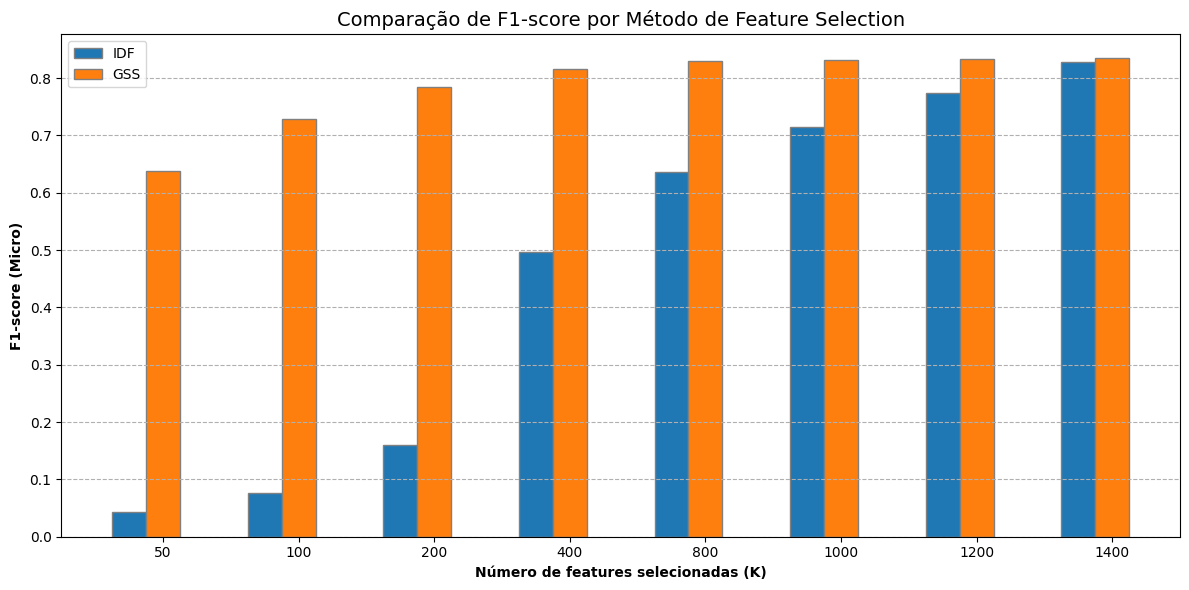

In [ ]:
# Transformando os resultados em um DataFrame
data_for_plot = []
for name, metrics in results.items(): # Itera sobre o dicionário de métricas
  f1s = metrics['F1'] # Acessa a lista de F1-scores
  for K, f1 in zip(K_values, f1s):
    data_for_plot.append({
      'K': K,
      'Método': name,
      'F1_Score': f1
    })

df_plot = pd.DataFrame(data_for_plot)

bar_width = 0.25
fig, ax = plt.subplots(figsize=(12, 6))

# Posições no eixo X para os grupos de K
r = np.arange(len(K_values))

# Itera sobre os métodos para plotar as barras
for i, name in enumerate(results.keys()):
  # Seleciona os dados para o método atual
  f1s = df_plot[df_plot['Método'] == name]['F1_Score'].values
  pos = r + (i * bar_width)

  ax.bar(pos, f1s, color=f'C{i}', width=bar_width, edgecolor='grey', label=name)

# Configurações Finais do Gráfico
ax.set_xlabel("Número de features selecionadas (K)", fontweight='bold')
ax.set_ylabel("F1-score (Micro)", fontweight='bold')
ax.set_title("Comparação de F1-score por Método de Feature Selection", fontsize=14)

# Define os ticks no centro do grupo de barras
ax.set_xticks(r + bar_width)
ax.set_xticklabels(K_values)

ax.legend()
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

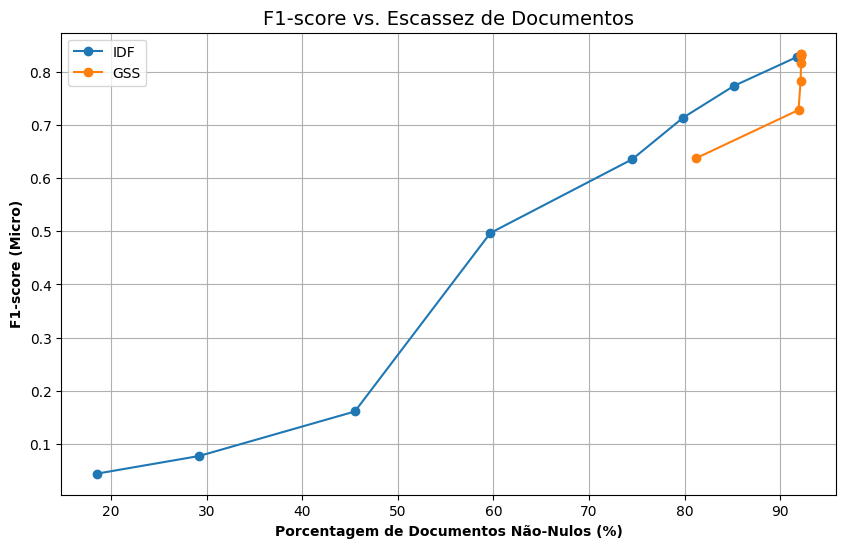

In [ ]:
plt.figure(figsize=(10, 6))

for name in results.keys():
  f1s = results[name]['F1']
  nonzero_pcts = results[name]['NonZero_Doc_Pct']

  # Plota a porcentagem no eixo X e o F1-score no eixo Y
  plt.plot(nonzero_pcts, f1s, marker='o', label=name)

plt.xlabel("Porcentagem de Documentos Não-Nulos (%)", fontweight='bold')
plt.ylabel("F1-score (Micro)", fontweight='bold')
plt.title("F1-score vs. Escassez de Documentos", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Mesmo código, muito mais feature

# Holdout
X_train, X_test, y_train_bin, y_test_bin = train_test_split(X, y_binarized, test_size=0.2, random_state=42) # 20% para testes como no artigo

# aIdentificar quais rótulos (colunas) têm pelo menos 1 exemplo positivo no treino
labels_in_train = y_train_bin.sum(axis=0) > 0

#  Identificar quais rótulos (colunas) têm pelo menos 1 exemplo positivo no teste
labels_in_test = y_test_bin.sum(axis=0) > 0

# Rótulos a serem mantidos: aqueles presentes tanto no treino quanto no teste.
labels_to_keep_mask = labels_in_train & labels_in_test

y_train_bin = y_train_bin[:, labels_to_keep_mask]
y_test_bin = y_test_bin[:, labels_to_keep_mask]

# Vetorização
tfidf = TfidfVectorizer(min_df=0.0002, max_df=0.9998)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

count = CountVectorizer(min_df=0.00025, max_df=0.99975)
X_train_count = count.fit_transform(X_train)
X_test_count = count.transform(X_test)

print(f"X_train_tfidf shape: {X_train_tfidf.shape}")
print(f"X_test_tfidf shape: {X_test_tfidf.shape}")

# Seleção de features
X_score = X_train_count

# Funções de pontuação
score_funcs = {
    "IDF": None,
    # "IG": aggregate_mutual_info,
    "GSS": aggregate_chi2
}

K_values = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000]
results = {name: {'F1': [], 'NonZero_Doc_Pct': []} for name in score_funcs.keys()}

for name, func in score_funcs.items():
  for K in K_values:
    if name == "IDF":
      idf_scores = tfidf.idf_
      top_idx = np.argsort(idf_scores)[::-1][:K]
    else:
      scores = func(X_score, y_train_bin)
      top_idx = np.argsort(scores)[::-1][:K]

    # Seleciona as K melhores features
    Xtr_sel = X_train_tfidf[:, top_idx]
    Xte_sel = X_test_tfidf[:, top_idx]

    nonzero_pct = calculate_nonzero_document_percentage(Xte_sel)
    results[name]['NonZero_Doc_Pct'].append(nonzero_pct)

    # Treinamento e Avaliação (LinearSVC)
    clf = OneVsRestClassifier(LinearSVC(random_state=42))
    clf.fit(Xtr_sel, y_train_bin)
    y_pred_bin = clf.predict(Xte_sel)

    # O argumento 'average="micro"' é crucial para classificação multi-classe
    f1 = f1_score(y_test_bin, y_pred_bin, average="micro")
    results[name]['F1'].append(f1)

    print(f"{name} K={K:<4} → F1={f1:.4f} | Non-Zero Docs={nonzero_pct:.2f}%")

X_train_tfidf shape: (9054, 9183)
X_test_tfidf shape: (2264, 9183)
IDF K=1000 → F1=0.0050 | Non-Zero Docs=12.28%
IDF K=2000 → F1=0.0127 | Non-Zero Docs=20.54%
IDF K=3000 → F1=0.0348 | Non-Zero Docs=31.14%
IDF K=4000 → F1=0.0667 | Non-Zero Docs=39.13%
IDF K=5000 → F1=0.1068 | Non-Zero Docs=47.88%
IDF K=6000 → F1=0.1791 | Non-Zero Docs=55.92%
IDF K=7000 → F1=0.2830 | Non-Zero Docs=64.22%
IDF K=8000 → F1=0.6130 | Non-Zero Docs=72.75%
IDF K=9000 → F1=0.7938 | Non-Zero Docs=86.53%
GSS K=1000 → F1=0.6079 | Non-Zero Docs=91.61%
GSS K=2000 → F1=0.6868 | Non-Zero Docs=92.09%
GSS K=3000 → F1=0.7414 | Non-Zero Docs=92.18%
GSS K=4000 → F1=0.7685 | Non-Zero Docs=92.18%
GSS K=5000 → F1=0.7820 | Non-Zero Docs=92.18%
GSS K=6000 → F1=0.7948 | Non-Zero Docs=92.18%
GSS K=7000 → F1=0.8082 | Non-Zero Docs=92.18%
GSS K=8000 → F1=0.8082 | Non-Zero Docs=92.18%
GSS K=9000 → F1=0.8082 | Non-Zero Docs=92.18%


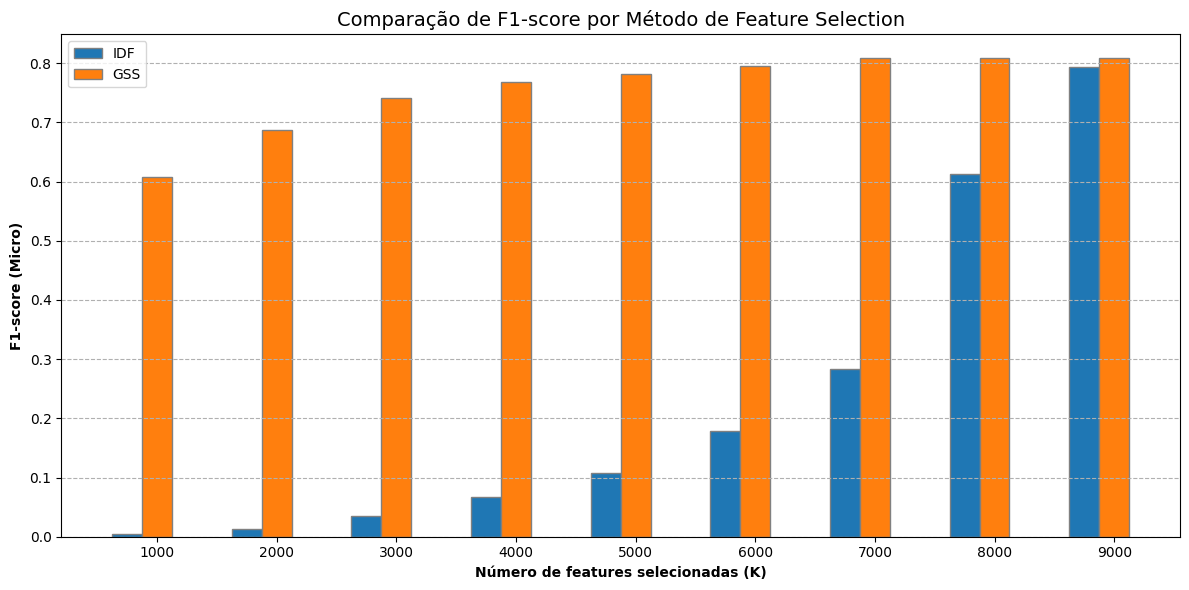

In [ ]:
# Transformando os resultados em um DataFrame
data_for_plot = []
for name, metrics in results.items(): # Itera sobre o dicionário de métricas
  f1s = metrics['F1'] # Acessa a lista de F1-scores
  for K, f1 in zip(K_values, f1s):
    data_for_plot.append({
      'K': K,
      'Método': name,
      'F1_Score': f1
    })

df_plot = pd.DataFrame(data_for_plot)

bar_width = 0.25
fig, ax = plt.subplots(figsize=(12, 6))

# Posições no eixo X para os grupos de K
r = np.arange(len(K_values))

# Itera sobre os métodos para plotar as barras
for i, name in enumerate(results.keys()):
  # Seleciona os dados para o método atual
  f1s = df_plot[df_plot['Método'] == name]['F1_Score'].values
  pos = r + (i * bar_width)

  ax.bar(pos, f1s, color=f'C{i}', width=bar_width, edgecolor='grey', label=name)

# Configurações Finais do Gráfico
ax.set_xlabel("Número de features selecionadas (K)", fontweight='bold')
ax.set_ylabel("F1-score (Micro)", fontweight='bold')
ax.set_title("Comparação de F1-score por Método de Feature Selection", fontsize=14)

# Define os ticks no centro do grupo de barras
ax.set_xticks(r + bar_width)
ax.set_xticklabels(K_values)

ax.legend()
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

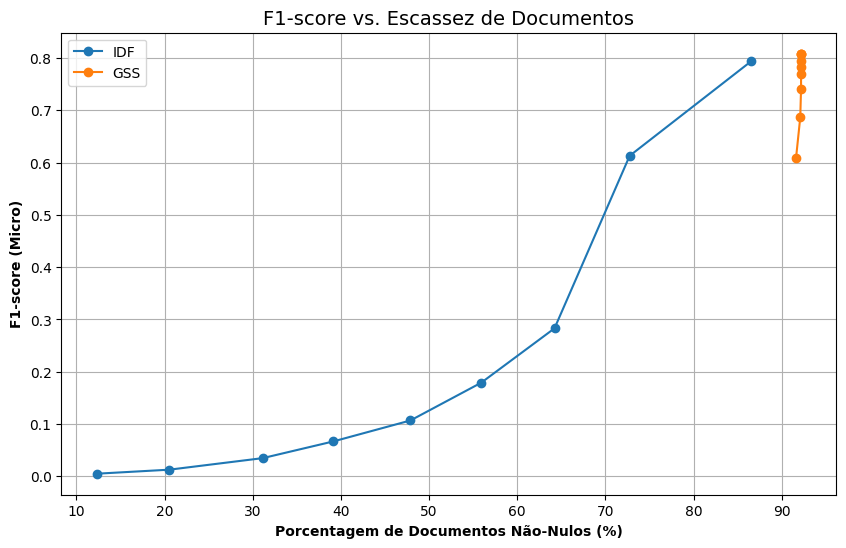

In [ ]:
plt.figure(figsize=(10, 6))

for name in results.keys():
  f1s = results[name]['F1']
  nonzero_pcts = results[name]['NonZero_Doc_Pct']

  # Plota a porcentagem no eixo X e o F1-score no eixo Y
  plt.plot(nonzero_pcts, f1s, marker='o', label=name)

plt.xlabel("Porcentagem de Documentos Não-Nulos (%)", fontweight='bold')
plt.ylabel("F1-score (Micro)", fontweight='bold')
plt.title("F1-score vs. Escassez de Documentos", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

# (3) Recriando método do artigo

## (3.0.1) Relação entre o artigo (Huang et al., 2018) e o código implementado:

Huang et al. (2018) → Abordagem multi-objetivo (maximizar informação por documento, minimizar número de features)

- Formulação como goal programming / 0-1 integer programming

- Resolução via Programação Dinâmica (DP)

- Implementação paralela do DP (speedup por núcleos) — função `dp_pareto_feature_selection_parallel`

- Integração no pipeline de classificação:

Vetorização (TF-IDF, max_features) → Seleção (DP paralelo) → Classificador (SVM / NB) → Avaliação (accuracy / F1)

Observação prática:
- No notebook implementamos tanto a versão exata via MILP (toy) quanto a versão DP / DP paralelo aplicada a conjuntos reais (Reuters).  
- As escolhas práticas (ex.: uso de `chi2` como score inicial, conversão TF-IDF → binário para o DP) estão alinhadas com as intenções do artigo, com pequenas adaptações para reprodutibilidade e velocidade.

## (3.0.2) Explicando o método (resumido)

Formulação:
$$
max ∑_i ∑_j s_j x_{ij} \\
min ∑_j y_j \\
s.t. y_j = 1, se ∃ x_{ij} = 1, x_{ij} ∈ {0, 1}
$$

Convertida em **goal programming** com desvios $h_1^{±}$, $h_2^{±}$:
$$
min Z = h_1^- + h_1^+ + h_2^- + h_2^+ \\
e \\
∑_i ∑_j s_j x_{ij} + h_1^- - h_1^+ = Φ, \\
∑_j y_j + h_2^- - h_2^+ = Ψ
$$
onde Φ e Ψ são metas (targets) para informação e número de features, respectivamente.


## (3.0.3) Explicando o método (+ simplificação)

### Formulação:

Variáveis:
- $x_{ij} ∈ {0, 1}$ — mantém feature $f_j$ no documento $d_i$ (1 = mantida)
- $y_{j} ∈ {0, 1}$ — se a feature $f_j$ foi selecionada para qualquer documento (isto é, aparece em pelo menos um documento mantido).

Parâmetros:
- $s_{jk}$ — score da feature $f_j$ na categoria $c_k$. (No artigo combinam por categoria; será usado um score agregado por feature ou documento para simplificar)
- $Φ$ — target de informação total desejada.
- $Θ$ — target no número de features desejado.

Objetivos:
1. Maximizar informação:
$$
  ∑_i ∑_j s_j x_{ij},
$$ (sintetizando $s_{jk}$ em $s_j$ agregado ou por documento)

2. Minimizar número de features:
$$
∑_j y_j
$$

Goal programming: transformar metas em igualdade com variáveis desvio $h_1^-$, $h_1^+$, $h_2^-$, $h_2^+$ e minimizar $Z = h_1^- + h_1^+ + h_2^- + h_2^+$ sujeito a:
- $∑_i ∑_j s_j x_{ij} + h_1^- - h_1^+ = Φ$
- $∑_j y_j + h_2^- - h_2^+ = Θ$
- ligação entre $x_{ij}$ e $y_j$: $y_j ≥ x_{ij}$ (para todo $i, j$) — garante $y_j = 1$ se algum $x_{ij} =1$. E $y_j ≤ ∑_i x_{ij}$.

**Observação prática**: O artigo formula variáveis $x_{ij}$ (por documento e feature) e $y_{j}$ (feature usada em algum documento). Isso é exato, porém produz muitas variáveis para coleções reais. A abordagem de programação dinâmica por subsets de features usa a observação prática: se uma feature $f_j$ é escolhida ($y_j = 1$), então para cada documento que contém $f_j$ podemos contar sua contribuição de informação automaticamente — portanto, a escolha efetiva é um subconjunto $Y$ de features. Essa simplificação será usada (sendo idêntica a que foi feita no artigo, ao tratar $x_{ij} = 1$, sempre que $y_j$ = 1 e $f_j$ aparecer no documento $i$).

## (3.1) Preparando ambiente e toy-dataset

toy-dataset: conjunto de dados pequeno e simples, usado para demonstração e testes.

In [ ]:
# Toy dataset
docs = [
    "apple banana apple orange",
    "banana kiwi banana apple",
    "carrot potato carrot",
    "apple potato banana",
    "kiwi orange banana"
]

# Construção do vocabulário simples e matriz term-doc binária
vec = CountVectorizer(binary=True)
X_bin = vec.fit_transform(docs).toarray() # shape (n_docs, n_features)
features = vec.get_feature_names_out()
n_docs, n_feat = X_bin.shape
print("features: ", features)
print("X_bin:\n", X_bin)

# Para scores s_j será usado um "score" sintético (p.ex. informação por feature)
# Na prática: utiliza-se IG/Chi2/MI por feature
rng = np.random.RandomState(42)
s_j = np.round(rng.uniform(0.1, 1.0, size=n_feat), 3) # scores entre 0.1 e 1.0
print("s_j: ", dict(zip(features, s_j)))

features:  ['apple' 'banana' 'carrot' 'kiwi' 'orange' 'potato']
X_bin:
 [[1 1 0 0 1 0]
 [1 1 0 1 0 0]
 [0 0 1 0 0 1]
 [1 1 0 0 0 1]
 [0 1 0 1 1 0]]
s_j:  {'apple': np.float64(0.437), 'banana': np.float64(0.956), 'carrot': np.float64(0.759), 'kiwi': np.float64(0.639), 'orange': np.float64(0.24), 'potato': np.float64(0.24)}


## (3.2) MILP / Goal programming (implementação direta) — para testar pequenos casos

In [ ]:
def solve_goal_programming(X_bin, s_j, Phi, Theta, time_limit=10):
  """
  X_bin: array numpy (n_docs, n_feat) matriz de presença binária
  s_j: formato do array (n_feat,) pontuações das features
  Phi: informação do alvo (float)
  Theta: número de features alvo (int)
  Retorna: dicionário com solução (features selecionadas y, matriz x) e objetivo Z
  """
  n_docs, n_feat = X_bin.shape
  prob = pulp.LpProblem("goal_prog", pulp.LpMinimize)

  # Variáveis
  x = pulp.LpVariable.dicts("x", [(i, j) for i in range(n_docs) for j in range(n_feat)], lowBound=0, upBound=1, cat="Binary")
  y = pulp.LpVariable.dicts("y", [j for j in range(n_feat)], lowBound=0, upBound=1, cat="Binary")

  # Variáveis ​​de desvio (contínuas, >=0)
  h = {}
  for name in ["h1neg","h1pos","h2neg","h2pos"]:
    h[name] = pulp.LpVariable(name, lowBound=0, cat="Continuous")

  # Objetivo: minimizar a soma dos desvios
  prob += h["h1neg"] + h["h1pos"] + h["h2neg"] + h["h2pos"]

  # Restrição 1: soma de informações + h1neg - h1pos = Phi
  info_expr = pulp.lpSum([ s_j[j] * x[(i,j)] for i in range(n_docs) for j in range(n_feat) if X_bin[i,j]==1 ])
  prob += info_expr + h["h1neg"] - h["h1pos"] == Phi

  # Restrição 2: número de features selecionadas + h2neg - h2pos = Theta
  prob += pulp.lpSum([ y[j] for j in range(n_feat) ]) + h["h2neg"] - h["h2pos"] == Theta

  # Ligando restrições: y_j >= x_ij para todos os i,j (ou seja, se xij=1 => yj=1)
  for i in range(n_docs):
    for j in range(n_feat):
      prob += y[j] >= x[(i,j)]

  # Além disso, x_ij só pode ser 1 se o recurso aparecer no documento: x_ij <= X_bin[i,j]
  for i in range(n_docs):
    for j in range(n_feat):
      if X_bin[i, j] == 0:
        prob += x[(i, j)] == 0

  # Resolver (será lento para casos maiores)
  prob.solve(pulp.PULP_CBC_CMD(msg=False, timeLimit=time_limit))

  status = pulp.LpStatus[prob.status]

  # Pega y e x
  y_sol = np.array([ int(pulp.value(y[j])) for j in range(n_feat) ])
  x_sol = np.zeros_like(X_bin)

  for i in range(n_docs):
    for j in range(n_feat):
      x_sol[i,j] = int(pulp.value(x[(i,j)]) or 0)

  Z = float(pulp.value(prob.objective))
  return {"status": status, "y": y_sol, "x": x_sol, "Z": Z, "info": float(sum(s_j[j]*x_sol[i,j] for i in range(n_docs) for j in range(n_feat)) ) }

# Testando MILP com toy dataset: Theta pequeno e Phi médio
Phi_test = 2.0
Theta_test = 3
res = solve_goal_programming(X_bin, s_j, Phi_test, Theta_test)

print("Status:", res["status"])
print("Features selecionadas (y):", res["y"])
print("Nome das features selecionadas:", [features[j] for j,v in enumerate(res["y"]) if v==1])
print("Informações obtidas:", res["info"], "Z:", res["Z"])
print("x matrix:\n", res["x"])

Status: Optimal
Features selecionadas (y): [0 0 0 1 1 1]
Nome das features selecionadas: ['kiwi', 'orange', 'potato']
Informações obtidas: 1.998 Z: 0.002
x matrix:
 [[0 0 0 0 1 0]
 [0 0 0 1 0 0]
 [0 0 0 0 0 1]
 [0 0 0 0 0 0]
 [0 0 0 1 1 0]]


## (3.3) Programação Dinâmica (DP)

Abordagem exata e escalável para o problema de seleção de features apresentada pelo artigo.

Ideia chave (simplificação): Se você escolhe um conjunto de features $Y$, a informação total é: $$
Info(Y) = ∑_i ∑_{j ∈ Y} s_j ⋅ [f_j ∈ d_i]
$$

ou seja, somamos para cada documento os scores das features escolhidas que aparecem nele. Portanto, o problema de multiobjetivo reduz-se a escolher um subconjunto $Y$ que ofereça tradeoffs ($|Y|$, $Info(Y)$). Podemos calcular o front de Pareto por DP sobre features (similar ao knapsack DP mas com duas dimensões tratadas como valores).

O DP constrói iterativamente o conjunto de soluções possíveis (contagem de features -> melhor info) e mantém apenas o front pareto a cada passo. Isso é eficiente e exato (não exige MILP) e é a essência do que o artigo descreve ao usar DP e manter soluções na memória.

In [ ]:
def dp_pareto_feature_selection(X_bin, s_j, features, keep_pareto=True):
  """
  DP sobre feature para calcular o front de Pareto de (num_features_selected -> max information).
  Retorna uma lista de tuplas: (selected_feature_indices_set, count, info)
  Para fins de tratabilidade, representamos conjuntos como frozensets.
  """

  n_docs, n_feat = X_bin.shape

  # pré-calcular a contribuição de cada feature para a informação total:
  # contrib_j = sum_i s_j * X_bin[i,j] = s_j * doc_freq_j
  doc_freq = X_bin.sum(axis=0)
  contrib = s_j * doc_freq # informação total contribuída se a feature j for selecionado (conta em todos os documentos)
  # No entanto, info(Y) é a soma das contribuições para as features em Y (já que as contribuições são aditivas)

  # DP: começa com um set vazio
  front = { frozenset(): 0.0 } # mapeamento: feature_set -> info_sum
  for j in range(n_feat):
    new_front = dict(front) # copia o que existe
    cj = float(contrib[j])
    for feat_set, info_val in front.items():
      new_set = feat_set.union({j})
      new_info = info_val + cj
      # mantém apenas se melhora
      if new_set not in new_front or new_info > new_front[new_set]:
        new_front[new_set] = new_info

    # Opcionalmente, podar conjuntos dominados para manter o tamanho gerenciável
    if keep_pareto:
      # construir mapeamento count->best_info (mantemos para cada contagem apenas as melhores informações)
      best_by_count = {}
      for sset, infov in new_front.items():
        cnt = len(sset)
        if cnt not in best_by_count or infov > best_by_count[cnt][1]:
          best_by_count[cnt] = (sset, infov)
      # reconstruir o front apenas com o melhor por contagem (poda drástica, mas mantendo a variedade)
      front = { s:info for s,(s,info) in [(v[0], (v[0], v[1])) for v in best_by_count.values()] }
    else:
      front = new_front

  # Converte para lista
  result = []
  for sset, infov in front.items():
    result.append( (sset, len(sset), float(infov)) )
  result = sorted(result, key=lambda x: (x[1], -x[2]))
  return result

# Testa DP no toy dataset
pareto = dp_pareto_feature_selection(X_bin, s_j, features, keep_pareto=True)
print("Candidatos Pareto encontrados (count, info, features):")
for sset, cnt, info in pareto:
    names = [features[i] for i in sorted(sset)]
    print(cnt, round(info,3), names)

Candidatos Pareto encontrados (count, info, features):
0 0.0 []
1 3.824 ['banana']
2 5.135 ['apple', 'banana']
3 6.413 ['apple', 'banana', 'kiwi']
4 7.172 ['apple', 'banana', 'carrot', 'kiwi']
5 7.652 ['apple', 'banana', 'carrot', 'kiwi', 'orange']
6 8.132 ['apple', 'banana', 'carrot', 'kiwi', 'orange', 'potato']


## (3.4) Paralelização (avaliar candidatos em paralelo)

No artigo, são geradas várias soluções por iteração, avaliando objetivos em paralelo.

In [ ]:
def eval_subset_info(subset, contrib):
  # subset: iterável de índices de features
  return sum(contrib[j] for j in subset)

# exemplo: avaliar todas combinações de 3 features
k = 3
subsets = list(combinations(range(n_feat), k))
contrib = s_j * X_bin.sum(axis=0)

res_parallel = Parallel(n_jobs=2)(delayed(eval_subset_info)(subset, contrib) for subset in subsets)

# Resultados dos pares
pairs = list(zip(subsets, res_parallel))

# Ordena for info desc
pairs_sorted = sorted(pairs, key=lambda x: x[1], reverse=True)
print("Melhores combinações de tamanho ", k)
for subset, info in pairs_sorted[:5]:
    print([features[i] for i in subset], round(info,3))

Melhores combinações de tamanho  3
['apple', 'banana', 'kiwi'] 6.413
['apple', 'banana', 'carrot'] 5.894
['banana', 'carrot', 'kiwi'] 5.861
['apple', 'banana', 'orange'] 5.615
['apple', 'banana', 'potato'] 5.615


## (3.5) Implementação: DP paralelizada

In [ ]:
def dp_pareto_feature_selection_parallel(X_bin, s_j, features, n_jobs=4, keep_pareto=True, seed=42):
  """
  Versão paralelizada da Programação Dinâmica para seleção de features.
  Feita com base no speedup descrito em Huang et al. (2018, Seção 3.4).

  Args:
    X_bin: matriz binária (docs x features)
    s_j: vetor de scores das features
    features: lista com nomes das features
    n_jobs: número de núcleos usados no paralelismo
    keep_pareto: se True, mantém apenas o melhor conjunto por contagem de features
    seed: semente para reprodutibilidade

  Retorna:
    Lista de tuplas (feature_set, count, info)
  """

  rng = np.random.RandomState(seed)
  n_docs, n_feat = X_bin.shape

  # Pré-calcular a contribuição de cada feature para a informação total:
  # contrib_j = sum_i s_j * X_bin[i,j] = s_j * doc_freq_j
  doc_freq = np.asarray(X_bin.sum(axis=0)).squeeze() # Ensure 1D array
  contrib = s_j * doc_freq # informação total contribuída se a feature j for selecionado (conta em todos os documentos)
  # No entanto, info(Y) é a soma das contribuições para as features em Y (já que as contribuições são aditivas)

  # DP: começa com um set vazio
  front = { frozenset(): 0.0 } # mapeamento: feature_set -> info_sum

  # Função para avaliar uma nova combinação (execução em paralelo)
  def evaluate_new_set(base_set, feature_to_add):
    new_set = base_set.union({feature_to_add})
    new_info = sum(contrib[j] for j in new_set)
    return new_set, new_info

  # Loop principal sobre as features
  for j in range(n_feat):
    cj = float(contrib[j])
    current_sets = list(front.keys())

    # Gera novas combinações a partir do front atual e distribui as avaliações entre núcleos
    tasks = [(base, j) for base in current_sets]
    results = Parallel(n_jobs=n_jobs)(delayed(evaluate_new_set)(base, f) for base, f in tasks)

    # Cria novo front combinando anteriores + novos
    new_front = dict(front)
    for new_set, new_info in results:
      if new_set not in new_front or new_info > new_front[new_set]:
        new_front[new_set] = new_info

    # Podar soluções dominadas
    if keep_pareto:
      best_by_count = {}
      for sset, infov in new_front.items():
        cnt = len(sset)
        if cnt not in best_by_count or infov > best_by_count[cnt][1]:
          best_by_count[cnt] = (sset, infov)
      front = {s: info for s, info in [v for v in best_by_count.values()]}
    else:
      front = new_front

  # Converte o front final em lista ordenada
  result = []
  for sset, infov in front.items():
    result.append((sset, len(sset), float(infov)))
  result = sorted(result, key=lambda x: (x[1], -x[2]))

  return result

In [ ]:
# Teste da versão paralela
pareto_parallel = dp_pareto_feature_selection_parallel(X_bin, s_j, features, n_jobs=4, keep_pareto=True)

print("Candidatos Pareto encontrados (count, info, features):")
for sset, cnt, info in pareto_parallel:
    names = [features[i] for i in sorted(sset)]
    print(cnt, round(info, 3), names)

Candidatos Pareto encontrados (count, info, features):
0 0.0 []
1 3.824 ['banana']
2 5.135 ['apple', 'banana']
3 6.413 ['apple', 'banana', 'kiwi']
4 7.172 ['apple', 'banana', 'carrot', 'kiwi']
5 7.652 ['apple', 'banana', 'carrot', 'kiwi', 'orange']
6 8.132 ['apple', 'banana', 'carrot', 'kiwi', 'orange', 'potato']


## (3.6) Avaliação do paralelismo

In [ ]:
def avaliar_tempo_pareto(X_train_tfidf, s_j, jobs_list, n_reps=3):
    """
    Avalia o tempo médio de execução da função dp_pareto_feature_selection_parallel
    variando o número de jobs (processos paralelos).

    Params:
        X_train_tfidf: matriz TF-IDF de treino
        s_j: vetor de scores das features
        jobs_list: lista com valores de n_jobs a testar (ex: [1, 2, 4, 8])
        n_reps: número de repetições para média (default 3)
    Retorna:
        tempos_médios: lista com o tempo médio de execução por n_jobs
    """
    tempos_medios = []

    for n in jobs_list:
        tempos = []
        print(f"\n🔹 Testando com n_jobs = {n} ...")
        for r in range(n_reps):
            inicio = time.time()
            pareto_parallel = dp_pareto_feature_selection_parallel(
                X_train_tfidf, s_j, list(range(X_train_tfidf.shape[1])),
                n_jobs=n, keep_pareto=True
            )
            fim = time.time()
            tempos.append(fim - inicio)
            print(f"   Execução {r+1}/{n_reps}: {tempos[-1]:.2f}s")
        tempo_medio = np.mean(tempos)
        tempos_medios.append(tempo_medio)
        print(f"Tempo médio ({n} jobs): {tempo_medio:.2f}s")

    return tempos_medios

In [ ]:
# Vetorização (Mantida)
tfidf = TfidfVectorizer(max_df=0.99, min_df=0.05)
X_tfidf = tfidf.fit_transform(X)

print(X_tfidf.shape)
print(y_binarized.shape)

# Pré-cálculo de uma medida de importância (ex.: chi2 scores)
chi2_scores_agg = aggregate_chi2(X_tfidf, y_binarized)
s_j = chi2_scores_agg

# Lista de quantidades de jobs a testar
jobs_list = [1, 2, 4, 8, -1]

# Avaliar tempos
tempos_medios = avaliar_tempo_pareto(X_tfidf, s_j, jobs_list)

(11318, 196)
(11318, 117)

🔹 Testando com n_jobs = 1 ...
   Execução 1/3: 0.39s
   Execução 2/3: 0.62s
   Execução 3/3: 0.91s
Tempo médio (1 jobs): 0.64s

🔹 Testando com n_jobs = 2 ...
   Execução 1/3: 9.58s
   Execução 2/3: 9.82s
   Execução 3/3: 7.94s
Tempo médio (2 jobs): 9.12s

🔹 Testando com n_jobs = 4 ...
   Execução 1/3: 9.46s
   Execução 2/3: 10.53s
   Execução 3/3: 9.31s
Tempo médio (4 jobs): 9.77s

🔹 Testando com n_jobs = 8 ...
   Execução 1/3: 11.36s
   Execução 2/3: 9.85s
   Execução 3/3: 9.57s
Tempo médio (8 jobs): 10.26s

🔹 Testando com n_jobs = -1 ...
   Execução 1/3: 7.64s
   Execução 2/3: 5.99s
   Execução 3/3: 6.74s
Tempo médio (-1 jobs): 6.79s


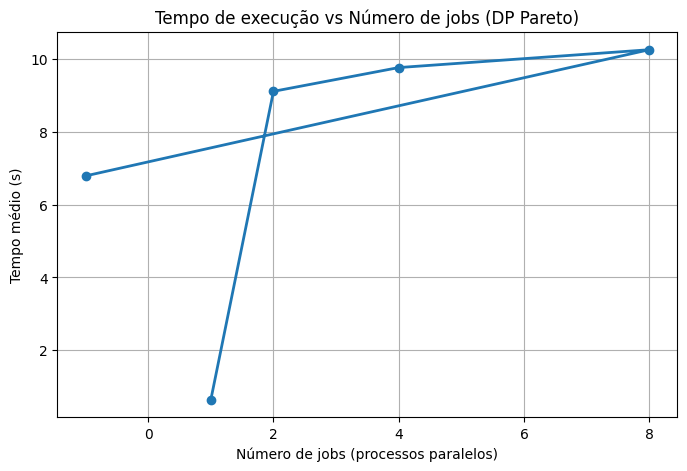

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(jobs_list, tempos_medios, marker='o', linewidth=2)
plt.title("Tempo de execução vs Número de jobs (DP Pareto)")
plt.xlabel("Número de jobs (processos paralelos)")
plt.ylabel("Tempo médio (s)")
plt.grid(True)
plt.show()

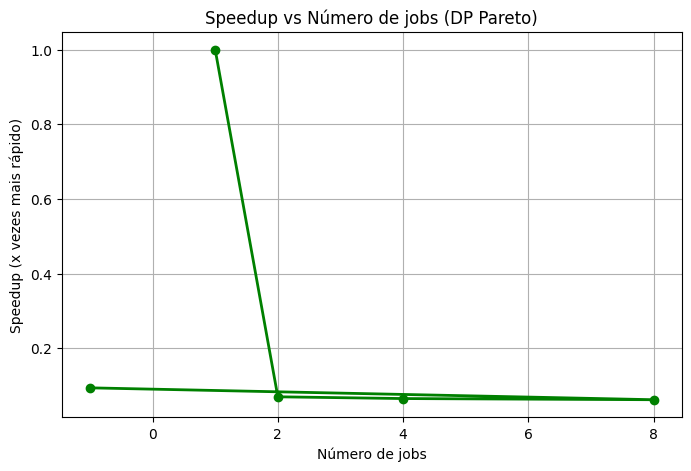

In [ ]:
speedup = [tempos_medios[0] / t for t in tempos_medios]

plt.figure(figsize=(8,5))
plt.plot(jobs_list, speedup, marker='o', color='green', linewidth=2)
plt.title("Speedup vs Número de jobs (DP Pareto)")
plt.xlabel("Número de jobs")
plt.ylabel("Speedup (x vezes mais rápido)")
plt.grid(True)
plt.show()

# (4) Avaliação no Reuters-21578 com MultinomialNB

## (4.1) Aplicando Holdout

In [ ]:
# Carregamento dos dados
X_train, X_test, y_train_bin, y_test_bin = train_test_split(X, y_binarized, test_size=0.2, random_state=42) # 20% para testes como no artigo

# Documentos totais no treino
total_train_docs = y_train_bin.shape[0]

# Rótulos presentes no treino (> 0 positivos)
labels_in_train = y_train_bin.sum(axis=0) > 0

# Rótulos presentes no teste (> 0 positivos)
labels_in_test = y_test_bin.sum(axis=0) > 0

# Rótulos NÃO SÃO todos positivos no treino (< total_train_docs positivos)
labels_not_all_positive_in_train = y_train_bin.sum(axis=0) < total_train_docs

# Rótulos a serem mantidos:
# - Presentes no treino E no teste (padrão do artigo)
# - E que NÃO sejam 100% positivos no treino (condição para evitar o UserWarning)
labels_to_keep_mask = labels_in_train & labels_in_test & labels_not_all_positive_in_train

# Aplicar a máscara
y_train_bin = y_train_bin[:, labels_to_keep_mask]
y_test_bin = y_test_bin[:, labels_to_keep_mask]

# Vetorização (Mantida)
tfidf = TfidfVectorizer(max_df=0.95, min_df=0.005)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(X_train_tfidf.shape)

(9054, 1421)


## (4.2) Criando modelos para comparação

In [ ]:
# Baseline com seleção de features (GridSearchCV com SelectKBest)

# Classificador base: OneVsRestClassifier envolvendo MultinomialNB
clf_base = OneVsRestClassifier(MultinomialNB())

# Pipeline: SelectKBest com chi2
pipe = Pipeline([
    ('select', SelectKBest(score_func=chi2)),
    ('clf', clf_base)
])

param_grid = {'select__k': [50, 100, 200, 400, 800, 1000, 1200, 1400]}

# GridSearchCV com a métrica F1-micro para otimização
grid = GridSearchCV(
    pipe,
    param_grid,
    scoring='f1_micro',
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train_tfidf, y_train_bin)

print("\n--- Baseline GridSearchCV ---")
print(f"Melhor K: {grid.best_params_['select__k']}")
print(f"Melhor F1-micro (CV): {grid.best_score_:.4f}")

# Reavalia no conjunto de teste com o melhor K
k_best = grid.best_params_['select__k']

# Refaz a Seleção de Features com o melhor K
select_best = SelectKBest(chi2, k=k_best).fit(X_train_tfidf, y_train_bin)
X_train_sel = select_best.transform(X_train_tfidf)
X_test_sel = select_best.transform(X_test_tfidf)

# Treina o classificador final
clf_grid = OneVsRestClassifier(MultinomialNB()) # Instancia um novo
clf_grid.fit(X_train_sel, y_train_bin)
y_pred_grid = clf_grid.predict(X_test_sel)

acc_grid = accuracy_score(y_test_bin, y_pred_grid)
f1_grid = f1_score(y_test_bin, y_pred_grid, average="micro")
print(f"Grid accuracy (Teste): {acc_grid:.4f}")
print(f"Grid F1-score (Teste): {f1_grid:.4f}")

Fitting 3 folds for each of 8 candidates, totalling 24 fits

--- Baseline GridSearchCV ---
Melhor K: 1400
Melhor F1-micro (CV): 0.6939
Grid accuracy (Teste): 0.5981
Grid F1-score (Teste): 0.7179


## (4.3) Aplicando o método DP Paralelo

In [ ]:
# Pré-cálculo de uma medida de importância (ex.: chi2 scores)
chi2_scores_agg = aggregate_chi2(X_train_tfidf, y_train_bin)
s_j = chi2_scores_agg

# Chamada da sua função paralela
pareto_parallel = dp_pareto_feature_selection_parallel(
    X_train_tfidf, s_j, list(range(X_train_tfidf.shape[1])), n_jobs=1, keep_pareto=True
)

# Seleciona o subconjunto com maior info/num_features balanceado
alpha = 0.001
best_subset_tuple = max(pareto_parallel, key=lambda x: x[2] - alpha * x[1])

# Converte o frozenset de índices (elemento [0]) para uma lista/array
best_subset_indices = sorted(list(best_subset_tuple[0]))

# Reduz a matriz para as features selecionadas (usa os índices diretamente)
X_train_dp = X_train_tfidf[:, best_subset_indices]
X_test_dp = X_test_tfidf[:, best_subset_indices]

# Treina o classificador
clf_dp = OneVsRestClassifier(MultinomialNB())
clf_dp.fit(X_train_dp, y_train_bin)
y_pred_dp = clf_dp.predict(X_test_dp)

acc_dp = accuracy_score(y_test_bin, y_pred_dp)
f1_dp = f1_score(y_test_bin, y_pred_dp, average="micro")

print("--- DP Pareto ---")
print(f"Features selecionadas (DP): {len(best_subset_indices)}")
print(f"DP Accuracy (Teste): {acc_dp:.4f}")
print(f"DP F1-score (Teste): {f1_dp:.4f}")

--- DP Pareto ---
Features selecionadas (DP): 1421
DP Accuracy (Teste): 0.5972
DP F1-score (Teste): 0.7166


In [ ]:
print("--- Resumo ---")
print(f"GridSearch:  acc={acc_grid:.4f}, f1={f1_grid:.4f} (K={k_best})")
print(f"DP Pareto:   acc={acc_dp:.4f}, f1={f1_dp:.4f} (K={len(best_subset_indices)})")

--- Resumo ---
GridSearch:  acc=0.5981, f1=0.7179 (K=1400)
DP Pareto:   acc=0.5972, f1=0.7166 (K=1421)


# (5) Avaliação no Reuters-21578 com LinearSVC

## (5.1) Criando modelos para comparação

In [ ]:
# Baseline com seleção de features (GridSearchCV com SelectKBest)

# Classificador base: OneVsRestClassifier envolvendo LinearSVC
clf_base = OneVsRestClassifier(LinearSVC(random_state=42))

# Pipeline: SelectKBest com chi2
pipe = Pipeline([
    ('select', SelectKBest(score_func=chi2)),
    ('clf', clf_base)
])

param_grid = {'select__k': [50, 100, 200, 400, 800, 1000, 1200, 1400]}

# GridSearchCV com a métrica F1-micro para otimização
grid = GridSearchCV(
    pipe,
    param_grid,
    scoring='f1_micro',
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train_tfidf, y_train_bin)

print("\n--- Baseline GridSearchCV ---")
print(f"Melhor K: {grid.best_params_['select__k']}")
print(f"Melhor F1-micro (CV): {grid.best_score_:.4f}")

# Reavalia no conjunto de teste com o melhor K
k_best = grid.best_params_['select__k']

# Refaz a Seleção de Features com o melhor K
select_best = SelectKBest(chi2, k=k_best).fit(X_train_tfidf, y_train_bin)
X_train_sel = select_best.transform(X_train_tfidf)
X_test_sel = select_best.transform(X_test_tfidf)

# Treina o classificador final
clf_grid = OneVsRestClassifier(LinearSVC(random_state=42))
clf_grid.fit(X_train_sel, y_train_bin)
y_pred_grid = clf_grid.predict(X_test_sel)

acc_grid = accuracy_score(y_test_bin, y_pred_grid)
f1_grid = f1_score(y_test_bin, y_pred_grid, average="micro")
print(f"Grid accuracy (Teste): {acc_grid:.4f}")
print(f"Grid F1-score (Teste): {f1_grid:.4f}")

Fitting 3 folds for each of 8 candidates, totalling 24 fits

--- Baseline GridSearchCV ---
Melhor K: 1400
Melhor F1-micro (CV): 0.8186
Grid accuracy (Teste): 0.7513
Grid F1-score (Teste): 0.8341


## (5.2) Aplicando o método DP Paralelo

In [ ]:
# Treina o classificador
clf_dp = OneVsRestClassifier(LinearSVC(random_state=42))
clf_dp.fit(X_train_dp, y_train_bin)
y_pred_dp = clf_dp.predict(X_test_dp)

acc_dp = accuracy_score(y_test_bin, y_pred_dp)
f1_dp = f1_score(y_test_bin, y_pred_dp, average="micro")

print("--- DP Pareto ---")
print(f"Features selecionadas (DP): {len(best_subset_indices)}")
print(f"DP Accuracy (Teste): {acc_dp:.4f}")
print(f"DP F1-score (Teste): {f1_dp:.4f}")

--- DP Pareto ---
Features selecionadas (DP): 1421
DP Accuracy (Teste): 0.7513
DP F1-score (Teste): 0.8342


In [ ]:
print("--- Resumo ---")
print(f"GridSearch:  acc={acc_grid:.4f}, f1={f1_grid:.4f} (K={k_best})")
print(f"DP Pareto:   acc={acc_dp:.4f}, f1={f1_dp:.4f} (K={len(best_subset_indices)})")

--- Resumo ---
GridSearch:  acc=0.7513, f1=0.8341 (K=1400)
DP Pareto:   acc=0.7513, f1=0.8342 (K=1421)


# (6) Avaliação no Reuters-21578 com RandomForest

In [ ]:
# Classificador base
clf_base_rf = OneVsRestClassifier(RandomForestClassifier(random_state=42, n_jobs=-1))

# Pipeline: SelectKBest + RandomForest
pipe_rf = Pipeline([
    ('select', SelectKBest(score_func=chi2)),
    ('clf', clf_base_rf)
])

# Faixa de K igual à usada com o RandomFoorest
param_grid_rf = {
    'select__k': [800, 1400],
    'clf__estimator__n_estimators': [100, 200],   # número de árvores
    'clf__estimator__max_depth': [None, 10, 20],  # profundidade máxima
}

# GridSearchCV com F1-micro
grid_rf = GridSearchCV(
    pipe_rf,
    param_grid_rf,
    scoring='f1_micro',
    cv=3,
    n_jobs=-1,
    verbose=2
)

# Treinamento
grid_rf.fit(X_train_tfidf, y_train_bin)

print("\n--- Baseline GridSearchCV (RandomForest) ---")
print(f"Melhor K: {grid_rf.best_params_['select__k']}")
print(f"Melhor F1-micro (CV): {grid_rf.best_score_:.4f}")

# Avaliação no conjunto de teste
k_best_rf = grid_rf.best_params_['select__k']

Fitting 3 folds for each of 12 candidates, totalling 36 fits

--- Baseline GridSearchCV (RandomForest) ---
Melhor K: 1400
Melhor F1-micro (CV): 0.7279


NameError: name 'best_params' is not defined

In [ ]:
best_params = grid_rf.best_params_
print(best_params)

# Reaplica SelectKBest com o melhor K
select_best_rf = SelectKBest(chi2, k=k_best_rf).fit(X_train_tfidf, y_train_bin)
X_train_sel_rf = select_best_rf.transform(X_train_tfidf)
X_test_sel_rf = select_best_rf.transform(X_test_tfidf)

# Treina o classificador final
clf_grid_rf = OneVsRestClassifier(
  RandomForestClassifier(
    random_state=42, n_jobs=-1,
    n_estimators=best_params['clf__estimator__n_estimators'],
    max_depth=best_params['clf__estimator__max_depth'],
))
clf_grid_rf.fit(X_train_sel_rf, y_train_bin)
y_pred_grid_rf = clf_grid_rf.predict(X_test_sel_rf)

acc_grid_rf = accuracy_score(y_test_bin, y_pred_grid_rf)
f1_grid_rf = f1_score(y_test_bin, y_pred_grid_rf, average="micro")

print(f"Grid accuracy (Teste): {acc_grid_rf:.4f}")
print(f"Grid F1-score (Teste): {f1_grid_rf:.4f}")

{'clf__estimator__max_depth': None, 'clf__estimator__n_estimators': 200, 'select__k': 1400}
Grid accuracy (Teste): 0.6515
Grid F1-score (Teste): 0.7548


In [ ]:
# === DP PARETO COM RANDOMFOREST ===
X_train_dp_rf = X_train_tfidf[:, best_subset_indices]
X_test_dp_rf = X_test_tfidf[:, best_subset_indices]

clf_dp_rf = OneVsRestClassifier(RandomForestClassifier(
    random_state=42, n_jobs=-1,
    n_estimators=200,
    max_depth=None
))

clf_dp_rf.fit(X_train_dp_rf, y_train_bin)
y_pred_dp_rf = clf_dp_rf.predict(X_test_dp_rf)

acc_dp_rf = accuracy_score(y_test_bin, y_pred_dp_rf)
f1_dp_rf = f1_score(y_test_bin, y_pred_dp_rf, average="micro")

print("\n--- DP Pareto (RandomForest) ---")
print(f"Features selecionadas (DP): {len(best_subset_indices)}")
print(f"DP Accuracy (Teste): {acc_dp_rf:.4f}")
print(f"DP F1-score (Teste): {f1_dp_rf:.4f}")

# === RESUMO FINAL ===
print("\n--- Resumo Comparativo ---")
print(f"GridSearch RF: acc={acc_grid_rf:.4f}, f1={f1_grid_rf:.4f} (K={k_best_rf})")
print(f"DP Pareto RF:  acc={acc_dp_rf:.4f}, f1={f1_dp_rf:.4f} (K={len(best_subset_indices)})")


--- DP Pareto (RandomForest) ---
Features selecionadas (DP): 1421
DP Accuracy (Teste): 0.6506
DP F1-score (Teste): 0.7538

--- Resumo Comparativo ---


NameError: name 'acc_grid_rf' is not defined

## Importância das Features com RF

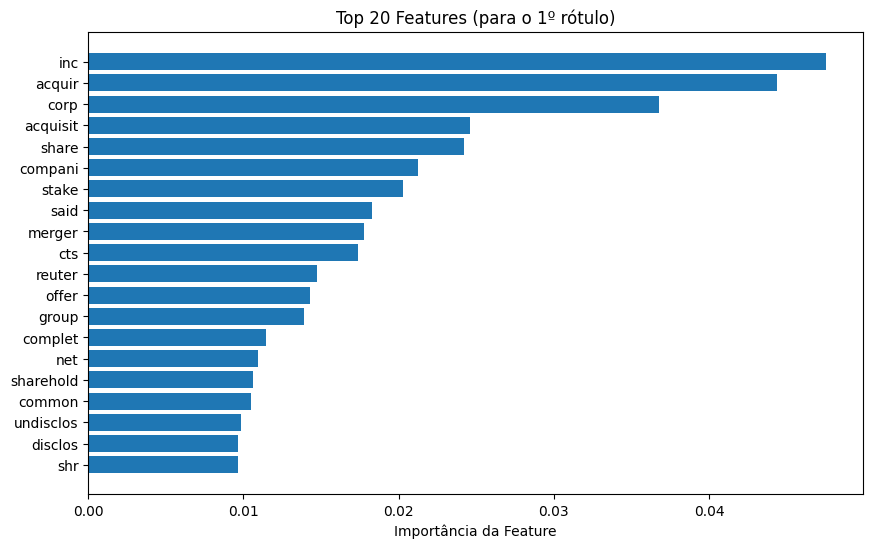

In [ ]:
# Extrai o modelo base (primeiro rótulo, por exemplo)
rf_estimator = clf_grid_rf.estimators_[0]

# Importância das features
importances = rf_estimator.feature_importances_

# Obtém os nomes das features selecionadas
selected_features = np.array(tfidf.get_feature_names_out())[select_best_rf.get_support(indices=True)]

# Ordena por importância
idx_sorted = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(10,6))
plt.barh(range(len(idx_sorted)), importances[idx_sorted][::-1])
plt.yticks(range(len(idx_sorted)), selected_features[idx_sorted][::-1])
plt.xlabel("Importância da Feature")
plt.title("Top 20 Features (para o 1º rótulo)")
plt.show()

## Visualização de uma árvore

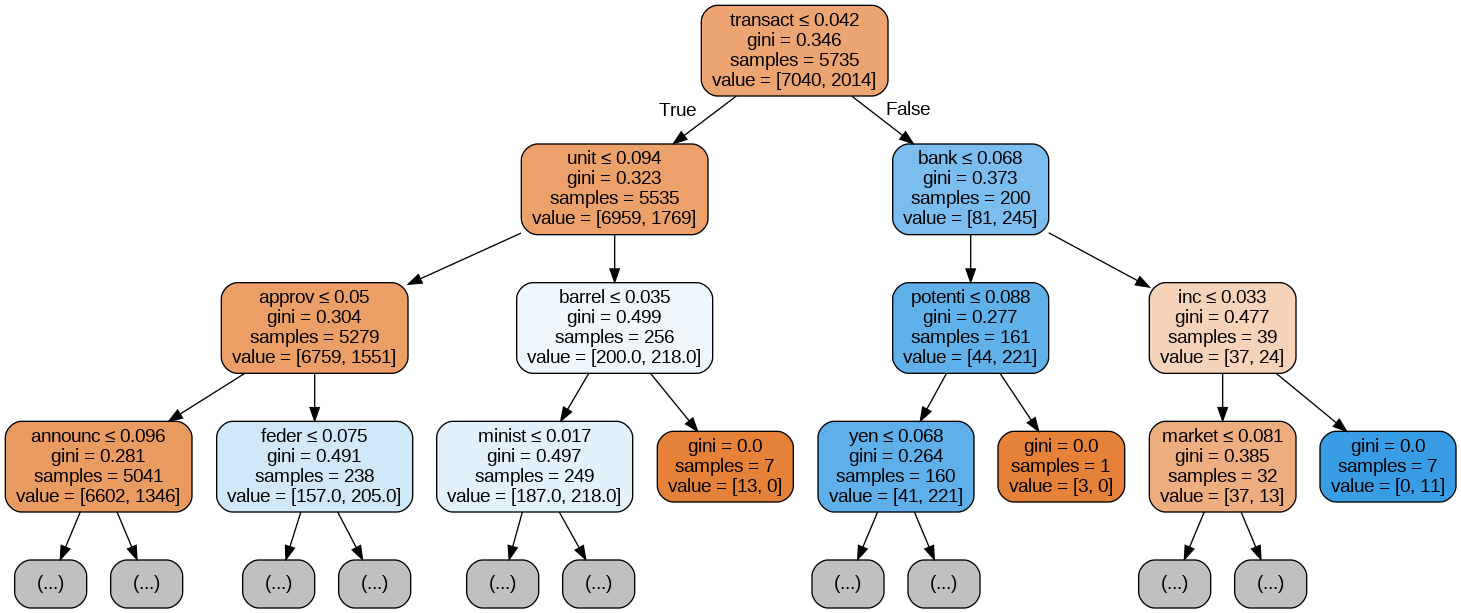

In [ ]:
# Extrai uma árvore individual
tree = rf_estimator.estimators_[0]

# Exporta para formato DOT (usando as features selecionadas)
dot_data = export_graphviz(
  tree,
  out_file=None,
  feature_names=selected_features,
  filled=True,
  rounded=True,
  special_characters=True,
  max_depth=3  # limita o tamanho do gráfico
)

graph = graphviz.Source(dot_data)
graph.render("tree_example", format="png", cleanup=True)
Image(filename="tree_example.png")

## Distribuição da importância

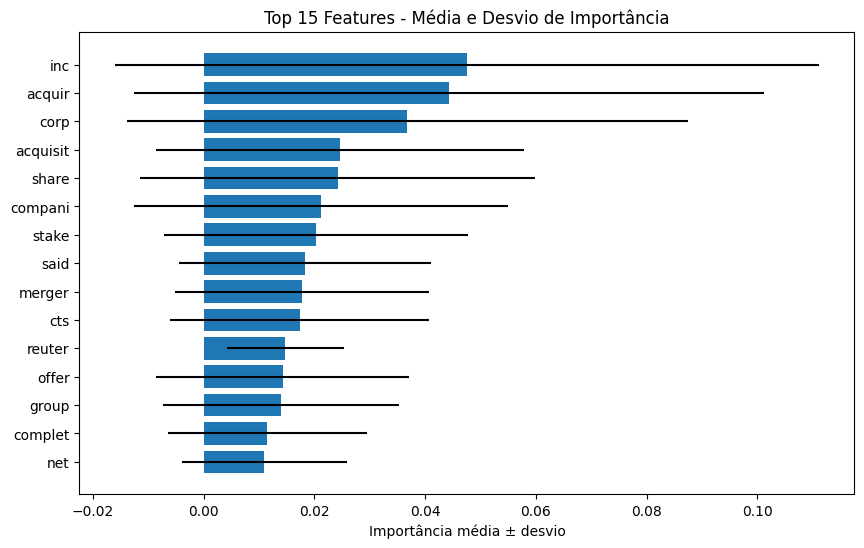

In [ ]:
# Importância média e desvio entre as árvores
importances_all = np.array([tree.feature_importances_ for tree in rf_estimator.estimators_])
mean_importances = importances_all.mean(axis=0)
std_importances = importances_all.std(axis=0)

feat_df = pd.DataFrame({
  'Feature': selected_features,
  'ImportanceMean': mean_importances,
  'ImportanceStd': std_importances
}).sort_values(by='ImportanceMean', ascending=False)

plt.figure(figsize=(10,6))
plt.barh(feat_df['Feature'][:15][::-1], feat_df['ImportanceMean'][:15][::-1], xerr=feat_df['ImportanceStd'][:15][::-1])
plt.title("Top 15 Features - Média e Desvio de Importância")
plt.xlabel("Importância média ± desvio")
plt.show()

## Comparação com o artigo


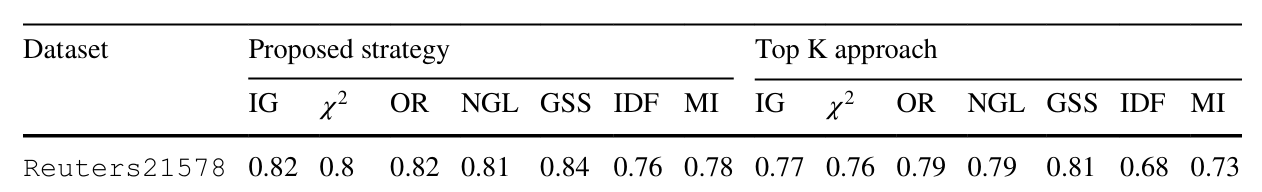